In [2]:
import time
import copy
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
with open("cfg/train_fn_tfidf_features.pkl", "rb") as fp:
    train_fn_tfidf_features = pickle.load(fp)

with open("cfg/train_fn_tfidf_labels.pkl", "rb") as fp:
    train_label = pickle.load(fp)

with open("cfg/test_fn_tfidf_features.pkl", "rb") as fp:
    test_tfidf_features = pickle.load(fp)

with open("cfg/real_fn_tfidf_features.pkl", "rb") as fp:
    real_tfidf_features = pickle.load(fp)

In [4]:
train_label = np.array(train_label, dtype=np.int32)

In [5]:
train_fn_tfidf_features.shape, train_label.shape, test_tfidf_features.shape, real_tfidf_features.shape

((6000, 115680), (6000,), (6000, 115680), (6007, 115680))

In [6]:
bc_model = BaggingClassifier()
gbc_model = GradientBoostingClassifier()
lr_model = LogisticRegression()
svm_model = svm.LinearSVC()
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(max_depth=7, learning_rate=0.05, n_estimators=500)

rfc_model = RandomForestClassifier(200)
etc_model = ExtraTreesClassifier()
mnb_model = naive_bayes.MultinomialNB(alpha=0.01)
ada_model = AdaBoostClassifier()

In [7]:
funtion_name_tfidf = {}

In [8]:
def get_oof(model, x_train, y_train, x_test, x_real, n_splits):
    score = []
    n_train, n_test, n_real = x_train.shape[0], x_test.shape[0], x_real.shape[0]
    kf = StratifiedKFold(n_splits=n_splits, random_state=0)
    oof_train = np.empty((n_train, ))
    oof_test = np.empty((n_test, ))
    oof_test_skf = np.empty((n_splits, n_test))
    oof_real = np.empty((n_real, ))
    oof_real_skf = np.empty((n_splits, n_real))
    models = []
    with tqdm(total=n_splits, ncols=80) as pbar:
        for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
            kf_x_train = x_train[train_index]
            kf_y_train = y_train[train_index]
            kf_x_test = x_train[test_index]
            model.fit(kf_x_train, kf_y_train)
            oof_train[test_index] = model.predict(kf_x_test)
            oof_test_skf[i, :] = model.predict(x_test)
            oof_real_skf[i, :] = model.predict(x_real)
            score.append(model.score(kf_x_train, kf_y_train))
            models.append(copy.deepcopy(model))
            pbar.update(1)
        oof_test[:] = oof_test_skf.mean(axis=0)
        oof_real[:] = oof_real_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_real.reshape(-1, 1), models, np.mean(score)

In [9]:
try:
    lr_model_oof_train, lr_model_oof_test, lr_model_oof_real, models, score = get_oof(lr_model, 
                                                                                train_fn_tfidf_features, 
                                                                                train_label,
                                                                                test_tfidf_features,
                                                                                real_tfidf_features,
                                                                                10)
    funtion_name_tfidf['lr'] = models
    print("lr success! {}".format(score))
except Exception as e:
    print("lr error! {}".format(e))

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]

lr success! 0.9758888888888888


In [10]:
try:
    gbc_model_oof_train, gbc_model_oof_test, gbc_model_oof_real, models, score = get_oof(gbc_model, 
                                                                                  train_fn_tfidf_features, 
                                                                                  train_label,
                                                                                  test_tfidf_features,
                                                                                  real_tfidf_features,
                                                                                  10)
    funtion_name_tfidf['gbc'] = models
    print("gbc success! {}".format(score))
except Exception as e:
    print("gbc error! {}".format(e))

  0%|                                                    | 0/10 [00:54<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
try:
    bc_model_oof_train, bc_model_oof_test, bc_model_oof_real, models, score = get_oof(bc_model, 
                                                                                train_fn_tfidf_features, 
                                                                                train_label,
                                                                                test_tfidf_features,
                                                                                real_tfidf_features,
                                                                                10)
    funtion_name_tfidf['bc'] = models
    print("bc success! {}".format(score))
except Exception as e:
    print("bc error! {}".format(e))

In [ ]:
try:
    svm_model_oof_train, svm_model_oof_test, svm_model_oof_real, models, score = get_oof(svm_model, 
                                                                                  train_fn_tfidf_features, 
                                                                                  train_label,
                                                                                  test_tfidf_features,
                                                                                  real_tfidf_features,
                                                                                  10)
    funtion_name_tfidf['svm'] = models
    print("svm success! {}".format(score))
except Exception as e:
    print("svm error! {}".format(e))

In [ ]:
try:
    dt_model_oof_train, dt_model_oof_test, dt_model_oof_real, models, score = get_oof(dt_model, 
                                                                                train_fn_tfidf_features, 
                                                                                train_label,
                                                                                test_tfidf_features,
                                                                                real_tfidf_features,
                                                                                10)
    funtion_name_tfidf['dt'] = models
    print("dt success! {}".format(score))
except Exception as e:
    print("dt error! {}".format(e))

In [ ]:
try:
    rfc_model_oof_train, rfc_model_oof_test, rfc_model_oof_real, models, score = get_oof(rfc_model, 
                                                                                  train_fn_tfidf_features, 
                                                                                  train_label,
                                                                                  test_tfidf_features,
                                                                                  real_tfidf_features,
                                                                                  10)
    funtion_name_tfidf['rfc'] = models
    print("rfc success! {}".format(score))
except Exception as e:
    print("rfc error! {}".format(e))

In [ ]:
try:
    etc_model_oof_train, etc_model_oof_test, etc_model_oof_real, models, score = get_oof(etc_model, 
                                                                                  train_fn_tfidf_features, 
                                                                                  train_label,
                                                                                  test_tfidf_features,
                                                                                  real_tfidf_features,
                                                                                  10)
    funtion_name_tfidf['etc'] = models
    print("etc success! {}".format(score))
except Exception as e:
    print("etc error! {}".format(e))

In [ ]:
try:
    mnb_model_oof_train, mnb_model_oof_test, mnb_model_oof_real, models, score = get_oof(mnb_model, 
                                                                                  train_fn_tfidf_features, 
                                                                                  train_label,
                                                                                  test_tfidf_features,
                                                                                  real_tfidf_features,
                                                                                  10)
    funtion_name_tfidf['mnb'] = models
    print("mnb success! {}".format(score))
except Exception as e:
    print("mnb error! {}".format(e))

In [ ]:
try:
    ada_model_oof_train, ada_model_oof_test, ada_model_oof_real, models, score = get_oof(ada_model, 
                                                                                  train_fn_tfidf_features, 
                                                                                  train_label,
                                                                                  test_tfidf_features,
                                                                                  real_tfidf_features,
                                                                                  10)
    funtion_name_tfidf['ada'] = models
    print("ada success! {}".format(score))
except Exception as e:
    print("ada error! {}".format(e))

In [ ]:
try:
    xgb_model_oof_train, xgb_model_oof_test, xgb_model_oof_real, models, score = get_oof(xgb_model, 
                                                                                  train_fn_tfidf_features, 
                                                                                  train_label,
                                                                                  test_tfidf_features,
                                                                                  real_tfidf_features,
                                                                                  10)
    funtion_name_tfidf['xgb'] = models
    print("xgb success! {}".format(score))
except Exception as e:
    print("xgb error! {}".format(e))

In [18]:
with open("models/funtion_name_tfidf.pkl", "wb") as fp:
    pickle.dump(funtion_name_tfidf, fp)

In [17]:
funtion_name_stacking_train_10 = np.hstack([lr_model_oof_train, gbc_model_oof_train, bc_model_oof_train,
                                            svm_model_oof_train, xgb_model_oof_train, dt_model_oof_train,
                                            rfc_model_oof_train, etc_model_oof_train, mnb_model_oof_train,
                                            ada_model_oof_train])
funtion_name_stacking_test_10 = np.hstack([lr_model_oof_test, gbc_model_oof_test, bc_model_oof_test,
                                           svm_model_oof_test, xgb_model_oof_test, dt_model_oof_test,
                                           rfc_model_oof_test, etc_model_oof_test, mnb_model_oof_test,
                                           ada_model_oof_test])
funtion_name_stacking_real_10 = np.hstack([lr_model_oof_real, gbc_model_oof_real, bc_model_oof_real,
                                           svm_model_oof_real, xgb_model_oof_real, dt_model_oof_real,
                                           rfc_model_oof_real, etc_model_oof_real, mnb_model_oof_real,
                                           ada_model_oof_real])

In [18]:
with open("oof/funtion_name_stacking_train_10.pkl", "wb") as fp:
    pickle.dump(funtion_name_stacking_train_10, fp)

with open("oof/funtion_name_stacking_test_10.pkl", "wb") as fp:
    pickle.dump(funtion_name_stacking_test_10, fp)

with open("oof/funtion_name_stacking_real_10.pkl", "wb") as fp:
    pickle.dump(funtion_name_stacking_real_10, fp)

In [19]:
with open("oof/funtion_name_stacking_train_10.pkl", "rb") as fp:
    funtion_name_stacking_train_10 = pickle.load(fp)

with open("oof/funtion_name_stacking_test_10.pkl", "rb") as fp:
    funtion_name_stacking_test_10 = pickle.load(fp)

with open("oof/funtion_name_stacking_real_10.pkl", "rb") as fp:
    funtion_name_stacking_real_10 = pickle.load(fp)

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(funtion_name_stacking_train_10, 
                                                                    train_label, 
                                                                    test_size=0.2, 
                                                                    random_state=1)

In [21]:
def plot(test_label, y_pred, model):
    font = {"color": "darkred",
            "size": 13, 
            "family" : "serif"}

    accs = accuracy_score(test_label, y_pred)
    fpr, tpr, _ = metrics.roc_curve(test_label,  y_pred)
    auc = metrics.roc_auc_score(test_label, y_pred)
    score = tpr[1] - 0.9*fpr[0]
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="{0}, auc={1:.2f}, score={2:.2f}".format(model, auc*100, score*100), color='green', linewidth=2)
    ax.set_title("ROC curve", fontdict=font)
    leg = ax.legend(loc="best")
    text = leg.get_texts()
    _ = plt.setp(text, color="blue") 

In [22]:
model = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, reg_lambda=0.4, seed=4396)
model.fit(train_data, train_labels)
y_pred = model.predict(test_data)

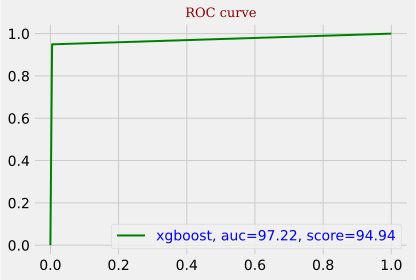

In [23]:
plot(test_labels, y_pred, "xgboost")

In [26]:
sum(model.predict(funtion_name_stacking_test_10))

1905

In [27]:
sum(model.predict(funtion_name_stacking_real_10))

1755